## Part I: Read Data and Pre-Process

Data Sourcing: 1.) Query into PH Department of Health Data (returns JSON), 2.) Extract values from JSON into Pandas Dataframe

In [65]:
import numpy as np
import pandas as pd

#Read JSON from src url
src_url = 'https://services5.arcgis.com/mnYJ21GiFTR97WFg/arcgis/rest/services/PH_masterlist/FeatureServer/0/query?f=json&where=1%3D1&returnGeometry=true&spatialRel=esriSpatialRelIntersects&outFields=%2A&outSR=102100&cacheHint=true&fbclid=IwAR38QbvClnSnwMEw23qlVwTBcgl_fqsFQaYNM1XiCThVVus0sBjclLyp8F0'

from urllib.request import urlopen
import json
from pandas.io.json import json_normalize
raw = json.loads(urlopen(src_url).read())
df = json_normalize(raw['features'])

#rename columns for easier navigation
df.rename(columns = lambda x: x.split('attributes.')[-1], inplace = True)

Column 'travel hx' contains a list of people interacted with and countries visited in paragraph format. Regex is used to obtain a list of contacts (of the form PHX) and store copies of exact contact code [PHX] and number only [X]. New values are stores in columns 'contacts' and 'contacts_num', respectively.

In [66]:
#include contact tracing to (sort of) map spread
import re
def get_contacts (s):
    try:
        return re.findall(r'\bPH\w+',s)
    except TypeError:
        return ""

df['contacts'] = df['travel_hx'].apply(lambda x: get_contacts(x))

def get_contacts_num (l):
    nums = []
    for i in l:
        nums.append(i.split('PH')[-1])
    return nums
        
df['contacts_num'] = df['contacts'].apply(lambda x: get_contacts_num(x))

## Part II: Connected Components Analysis

<b>Step 1:</b> Create a graph to map all <u>direct connections</u> of each case.

In [67]:
#Create an undirected graph of all connections
contact_map = {}
def add_edge(s, d, curr_dict):
    try:
        curr_dict[s].append(d)
    except KeyError:
        curr_dict[s] = []
        curr_dict[s].append(d)

for row in df.itertuples():
    current = getattr(row, 'FID')
    contact_list = getattr(row, 'contacts_num')
    for c in pd.Series(contact_list).unique():
        add_edge(int(current), int(c), contact_map)
        add_edge(int(c), int(current), contact_map)
    
    if(len(contact_list)==0):
        contact_map[current] = []

for key in contact_map.keys():
    contact_map[key] = list(set(contact_map[key]))

<b>Step 2:</b> Use Depth First Search on the graph built in Step 1 to a.) identify <i>networks</i> of inter-connected cases and b.) count the number of networks and the number of cases in each network.

In [68]:
cnt = len(df)
visited = [False for i in range(1,cnt+2)]
visited_pre = [False for i in range(1,cnt+2)]
parent = [-1 for i in range(1,cnt+2)]
def dfs (v, g):
    #dfs from node v in graph (dict) g
    visited[v] = True
    for node in g[v]:
        if(not visited[node]):
            parent[node] = v
            dfs(node, g)
            
cnt_cc = 0
comp_list = {}
for i in range(1, cnt+1):
    if(not visited[i]):
        cnt_cc+=1
        dfs(i, contact_map)
        comp_list[cnt_cc-1] = []
        
        for j in range(1, cnt+1):
            if(not visited_pre[j] and visited[j]):
                visited_pre[j] = visited[j]
                comp_list[cnt_cc-1].append(j)

<b>a. Multiple cases, especially the initial ones can be traced to networks of 3+ people where transmission occured.</b> The largest network is comprised of 8 people: [12, 34, 35, 42, 43, 84, 86, 204].
<br>
<br>
<i>List of all networks with 3+ Cases shown below:</i>

In [73]:
print("List of all Networks with 3+ cases:")
for key in comp_list.keys():
    current_list = []
    if(len(comp_list[key])>=3):
        for i in comp_list[key]:
            current_list = current_list + ['PH' + str(i)]
        print(f'Network {key}: {current_list}')

List of all Networks with 3+ cases:
Network 3: ['PH5', 'PH6', 'PH38']
Network 6: ['PH9', 'PH27', 'PH28', 'PH29', 'PH30', 'PH31']
Network 9: ['PH12', 'PH34', 'PH35', 'PH42', 'PH43', 'PH84', 'PH86', 'PH204']
Network 16: ['PH21', 'PH65', 'PH66', 'PH67']
Network 28: ['PH41', 'PH44', 'PH87', 'PH112']
Network 33: ['PH49', 'PH52', 'PH183']
Network 35: ['PH51', 'PH134', 'PH135']
Network 140: ['PH169', 'PH170', 'PH176']


<b>b. Largest Network (Network 9) has loose connections and is split among multiple hospitals in NCR across 10 days. </b> <br>
<i>Network details are shown below:</i>

In [75]:
df[df['FID'].isin(comp_list[9])]

,FID,PH_masterl,confirmed,edad,epi_link,facility,kasarian,latitude,longitude,nationalit,petsa,residence,status,symptoms,travel_hx,geometry.x,geometry.y,contacts,contacts_num
11,12,PH12,3/9/2020,56,,Makati Medical Center,Male,14.559177,121.014546,Filipino,3/8/2020 16:00,Manila,,,"Contact of PH42, PH43",1.347128e+07,1.638449e+06,"[PH42, PH43]","[42, 43]"
33,34,PH34,3/11/2020,72,,Lung Center of the Philippines,Male,14.647821,121.045763,Filipino,3/10/2020 16:00,Makati City,,,Husband of PH35,1.347475e+07,1.648646e+06,[PH35],[35]
34,35,PH35,3/11/2020,67,,Manila Doctors Hospital,Female,14.582028,120.982657,Filipino,3/10/2020 16:00,Makati City,,,Wife of PH34,1.346773e+07,1.641077e+06,[PH34],[34]
41,42,PH42,3/11/2020,51,,Lung Center of the Philippines,Female,14.647821,121.045763,Filipino,3/10/2020 16:00,Pasig City,,,Japan,1.347475e+07,1.648646e+06,[],[]
42,43,PH43,3/11/2020,47,,Lung Center of the Philippines,Male,14.647821,121.045763,Filipino,3/10/2020 16:00,Makati City,,,Wife is Sister of PH12; Close Contact of PH35,1.347475e+07,1.648646e+06,"[PH12, PH35]","[12, 35]"
83,84,PH84,3/13/2020,38,,Research Institute for Tropical Medicine,Female,14.409523,121.037122,Filipino,3/12/2020 16:00,Taguig City,,,Contact of PH43,1.347379e+07,1.621242e+06,[PH43],[43]
85,86,PH86,3/13/2020,48,,Research Institute for Tropical Medicine,Male,14.409523,121.037122,Filipino,3/12/2020 16:00,Quezon City,,,Contact of PH43,1.347379e+07,1.621242e+06,[PH43],[43]
203,204,PH204,3/18/2020,32,,Manila Doctors Hospital,Female,14.582028,120.982657,Filipino,3/18/2020,For validation,,,Contact of PH35,1.346773e+07,1.641077e+06,[PH35],[35]


<b>c. Certain people are also more inclined to spread to a large number of people, despite not being the first case in their network.</b><br>
<i>Shown below are cases with known exposure to 3 of more cases:</i>

In [76]:
print("List of all cases with 3+ contacts:")
for key in contact_map.keys():
    current_list = []
    if(len(contact_map[key])>=3):
        for i in contact_map[key]:
            current_list = current_list + ['PH' + str(i)]
        print(f'Case: PH{key}')
        print(f'Contacts: {current_list}')

List of all cases with 3+ contacts:
Case: PH9
Contacts: ['PH27', 'PH28', 'PH29', 'PH30', 'PH31']
Case: PH43
Contacts: ['PH35', 'PH12', 'PH86', 'PH84']
Case: PH21
Contacts: ['PH65', 'PH66', 'PH67']
Case: PH35
Contacts: ['PH34', 'PH43', 'PH204']
Case: PH41
Contacts: ['PH112', 'PH44', 'PH87']
Case: PH44
Contacts: ['PH112', 'PH41', 'PH87']
Case: PH87
Contacts: ['PH112', 'PH41', 'PH44']
Case: PH112
Contacts: ['PH41', 'PH44', 'PH87']


<b>d. Currently, there are 274 unique networks, although the number may decrease as more case information is collected. Additionally, 10.75% of all cases come from networks of 2+ people.</b>

In [72]:
print("Number of unique networks: ", cnt_cc)
print(f"Percentage of Transmissions in networks of 2+: {round(100*(1-cnt_cc/cnt),2)}%")

Number of unique networks:  274
Percentage of Transmissions in networks of 2+: 10.75%


## Part III: Conclusion

Much has already been said on the importance of <b>flattening the curve.</b> It can be shown that flattening the curve for the country begins with flattening the curve for each of the networks. That is, we should stop the networks of connected cases from growing. This can be accomplished with appropriate personal hygeine measures and social distancing whenever possible. 

### Functions

In [146]:
def get_case_plot(df):
    """
    This function generates the case growth curve for the given dataframe (df)
    The dataframe should be in the format of the data extracted in part I
    The dataframe can be the orginal df or a subset. Usage shown below
    """
    
    #decision is to use column 'confirmed.' see Data Validation section for details
    case_dates = df['confirmed']

    def get_date_part(s):
        try:
            return s.split(' ')[0]
        except AttributeError:
            return ""

    case_dates = case_dates.apply(lambda x: get_date_part(x))
    case_count = pd.DataFrame(case_dates[case_dates != ''].unique())
    
    case_count.rename(columns = {0: 'date'}, inplace = True)
    for row in case_count.itertuples():
        current_date = getattr(row, 'date')
        case_count.loc[getattr(row, 'Index'), 'case_count'] = len(df[df['confirmed']==current_date])

    for i in range(1, len(case_count)):
        case_count.loc[i, 'case_count'] += case_count.loc[i-1, 'case_count']
        
    #plot
    plt.plot(case_count['date'], case_count['case_count'])

### Background

<b>Growth of confirmed cases in PH</b>
<br><i>As of today, the growth of total PH cases is still rising</i>

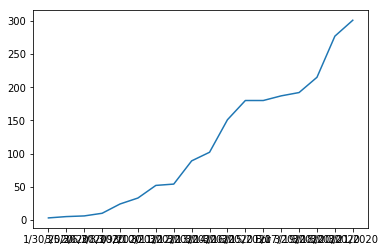

In [143]:
get_case_plot(df)

<b>Growth of confirmed cases within networks</b>
<br><i>On the bright side, we aren't reporting any new cases from our identified large networks. This could mean that contact tracing and quarantine recommendations to these networks have been effective. </i>

<i>Case growth within Network 9</i>

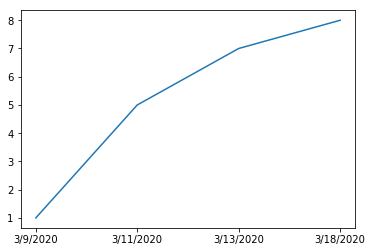

In [144]:
get_case_plot(df[df['FID'].isin(comp_list[9])])

<i>Case growth within Network 6</i>

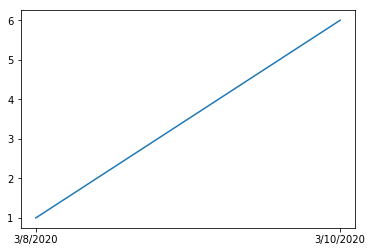

In [145]:
get_case_plot(df[df['FID'].isin(comp_list[6])])

### Data Validation

<i>Decision: use 'confirmed' vs. 'petsa' because it has more complete values (only 1 missing) vs. petsa (7 missing) even for confirmed cases.</i>

In [139]:
df[(df['confirmed'] == 'For Validation')| (df['confirmed'] == 'For validation')]

,FID,PH_masterl,confirmed,edad,epi_link,facility,kasarian,latitude,longitude,nationalit,petsa,residence,status,symptoms,travel_hx,geometry.x,geometry.y,contacts,contacts_num
110,111,PH111,For Validation,44,,St. Luke's Medical Center - Global City,Male,14.555128,121.048256,Filipino,3/13/2020 16:00,Pasig City,,,None,1.347503e+07,1.637983e+06,[],[]
205,206,PH206,For validation,25,,The Medical City - Ortigas,Male,14.589890,121.069315,Filipino,,Pasig City,,,None,1.347737e+07,1.641981e+06,[],[]
206,207,PH207,For validation,36,,The Medical City - Ortigas,Male,14.589890,121.069315,Filipino,,Rizal,,,None,1.347737e+07,1.641981e+06,[],[]
217,218,PH218,For validation,30,,St. Luke's Medical Center - Global City,Male,14.555128,121.048256,Filipino,,For validation,,,For validation,1.347503e+07,1.637983e+06,[],[]
266,267,PH267,For validation,56,None,Dr. Pablo O. Torre Memorial Hospital,Male,10.682441,122.958033,For validation,None,For validation,None,None,None,1.368763e+07,1.196114e+06,,[]
268,269,PH269,For validation,51,None,Research Institute for Tropical Medicine,Male,14.409523,121.037122,For validation,None,For validation,None,None,None,1.347379e+07,1.621242e+06,,[]


In [140]:
df[(df['petsa']==None) | (df['petsa'] == ' ')]

,FID,PH_masterl,confirmed,edad,epi_link,facility,kasarian,latitude,longitude,nationalit,petsa,residence,status,symptoms,travel_hx,geometry.x,geometry.y,contacts,contacts_num
204,205,PH205,3/18/2020,73,,The Medical City - Ortigas,Female,14.589890,121.069315,Filipino,,San Juan City,,,None,1.347737e+07,1.641981e+06,[],[]
205,206,PH206,For validation,25,,The Medical City - Ortigas,Male,14.589890,121.069315,Filipino,,Pasig City,,,None,1.347737e+07,1.641981e+06,[],[]
206,207,PH207,For validation,36,,The Medical City - Ortigas,Male,14.589890,121.069315,Filipino,,Rizal,,,None,1.347737e+07,1.641981e+06,[],[]
209,210,PH210,3/18/2020,81,,Chinese General Hospital and Medical Center,Male,14.625691,120.988565,Filipino,,San Juan City,,,None,1.346839e+07,1.646100e+06,[],[]
217,218,PH218,For validation,30,,St. Luke's Medical Center - Global City,Male,14.555128,121.048256,Filipino,,For validation,,,For validation,1.347503e+07,1.637983e+06,[],[]
225,226,PH226,3/20/2020,33,,De Los Santos Medical Center,Male,14.620153,121.017477,Filipino,,For validation,,,For validation,1.347160e+07,1.645463e+06,[],[]
226,227,PH227,3/20/2020,69,,St. Luke's Medical Center - Quezon City,Male,14.622677,121.023532,Filipino,,For validation,,,For validation,1.347228e+07,1.645753e+06,[],[]
227,228,PH228,3/20/2020,55,,St. Luke's Medical Center - Quezon City,Male,14.622677,121.023532,Filipino,,For validation,,,For validation,1.347228e+07,1.645753e+06,[],[]
228,229,PH229,3/20/2020,36,,St. Luke's Medical Center - Quezon City,Male,14.622677,121.023532,Filipino,,For validation,,,For validation,1.347228e+07,1.645753e+06,[],[]
229,230,PH230,3/20/2020,57,,Research Institute for Tropical Medicine,Female,14.409523,121.037122,For validation,,For validation,,,For validation,1.347379e+07,1.621242e+06,[],[]
